# 1. WCZYTANIE DANYCH


In [37]:
! pip install split-folders

In [38]:
! pip install -q kaggle

In [39]:
from google.colab import files

In [40]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"awwyii","key":"da7728cbe66945c08ea31a7d0f56f7f6"}'}

In [41]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [42]:
! cp kaggle.json ~/.kaggle/

In [43]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [44]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 99% 1.02G/1.03G [00:05<00:00, 180MB/s]
100% 1.03G/1.03G [00:05<00:00, 212MB/s]


In [45]:
!unzip \*.zip && rm *.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: a

Import potrzebnych modułów:
1. Conv2D, MaxPooling2D – warstwy CNN
2. Dropout, BatchNormalization – regularizacja
3. ImageDataGenerator – augmentacja obrazów
4. Adam – optymalizator

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import splitfolders
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Podział zbioru na: 80% treningowy, 10% walidacyjny oraz 10% testowy (podział folderów zachowany)

In [47]:
# podział zbioru
splitfolders.ratio(
    '/content/asl_alphabet_train/asl_alphabet_train',
    output='/content/working',
    seed=2000,
    ratio=(0.8, 0.1, 0.1)
)

Copying files: 87000 files [00:21, 3961.99 files/s]


# 2. Pipeline przetwarzania obrazów i konstrukcji modelu CNN

2.1 Parametry i przygotowanie danych

In [48]:
img_size = (64, 64)  # przeskalowanie na 64x64 px
batch_size = 32
epochs = 10
learning_rate = 0.001


2.2 Augmentacja danych – ImageDataGenerator

In [49]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2
)


2.3 Generatory danych – flow_from_directory

Generator treningowy

In [50]:
train_generator = datagen.flow_from_directory(
    'working/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 69600 images belonging to 29 classes.


Generator walidacyjny

In [51]:
val_generator = datagen.flow_from_directory(
    'working/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8700 images belonging to 29 classes.


Generator testowy

In [52]:
test_generator = datagen.flow_from_directory(
    'working/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8700 images belonging to 29 classes.


Wyświetlenie przykładowych obrazów

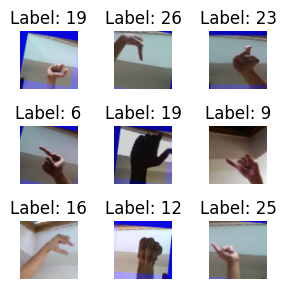

In [53]:
images, labels = next(train_generator)

num_images = 9
plt.figure(figsize=(3, 3))

for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

2.3 Model CNN – Sequential

In [54]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])

In [55]:
model.compile( #konfiguracja modelu przed trenowaniem
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True), #wczesne zatrzymanie
    ModelCheckpoint('best_model.keras', save_best_only=True) #zapisanie najlepszego
]

history = model.fit( #trenowanie modelu przez epoki
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1054s 483ms/step - accuracy: 0.0910 - loss: 3.2278 - val_accuracy: 0.3147 - val_loss: 2.0618
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1041s 479ms/step - accuracy: 0.2809 - loss: 2.2419 - val_accuracy: 0.4844 - val_loss: 1.5274
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1002s 461ms/step - accuracy: 0.4302 - loss: 1.7060 - val_accuracy: 0.6241 - val_loss: 1.0611
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1027s 472ms/step - accuracy: 0.5537 - loss: 1.3085 - val_accuracy: 0.7260 - val_loss: 0.7888
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1018s 468ms/step - accuracy: 0.6472 - loss: 1.0225 - val_accuracy: 0.7476 - val_loss: 0.8029
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1020s 469ms/step - accuracy: 0.7059 - loss: 0.8504 - val_accuracy: 0.8441 - val_loss: 0.4457
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1001s 460ms/step - accuracy: 0.7581 - loss: 0.7026 - val_accuracy: 0.8824 - val_loss: 0.3440
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1004s 461ms/s

# 3. Ewaluacja

272/272 ━━━━━━━━━━━━━━━━━━━━ 44s 163ms/step - accuracy: 0.9503 - loss: 0.1530
Validation accuracy: 0.9410
Validation loss:     0.1800
272/272 ━━━━━━━━━━━━━━━━━━━━ 43s 155ms/step

Validation Classification Report:

              precision    recall  f1-score   support

           A       0.97      0.93      0.95       300
           B       0.96      0.97      0.96       300
           C       0.98      1.00      0.99       300
           D       0.98      0.96      0.97       300
           E       0.91      0.94      0.93       300
           F       1.00      0.99      0.99       300
           G       0.98      0.87      0.92       300
           H       0.84      1.00      0.91       300
           I       0.96      0.98      0.97       300
           J       0.94      0.94      0.94       300
           K       0.92      0.98      0.95       300
           L       0.99      0.99      0.99       300
           M       0.91      0.85      0.88       300
           N       0.82      

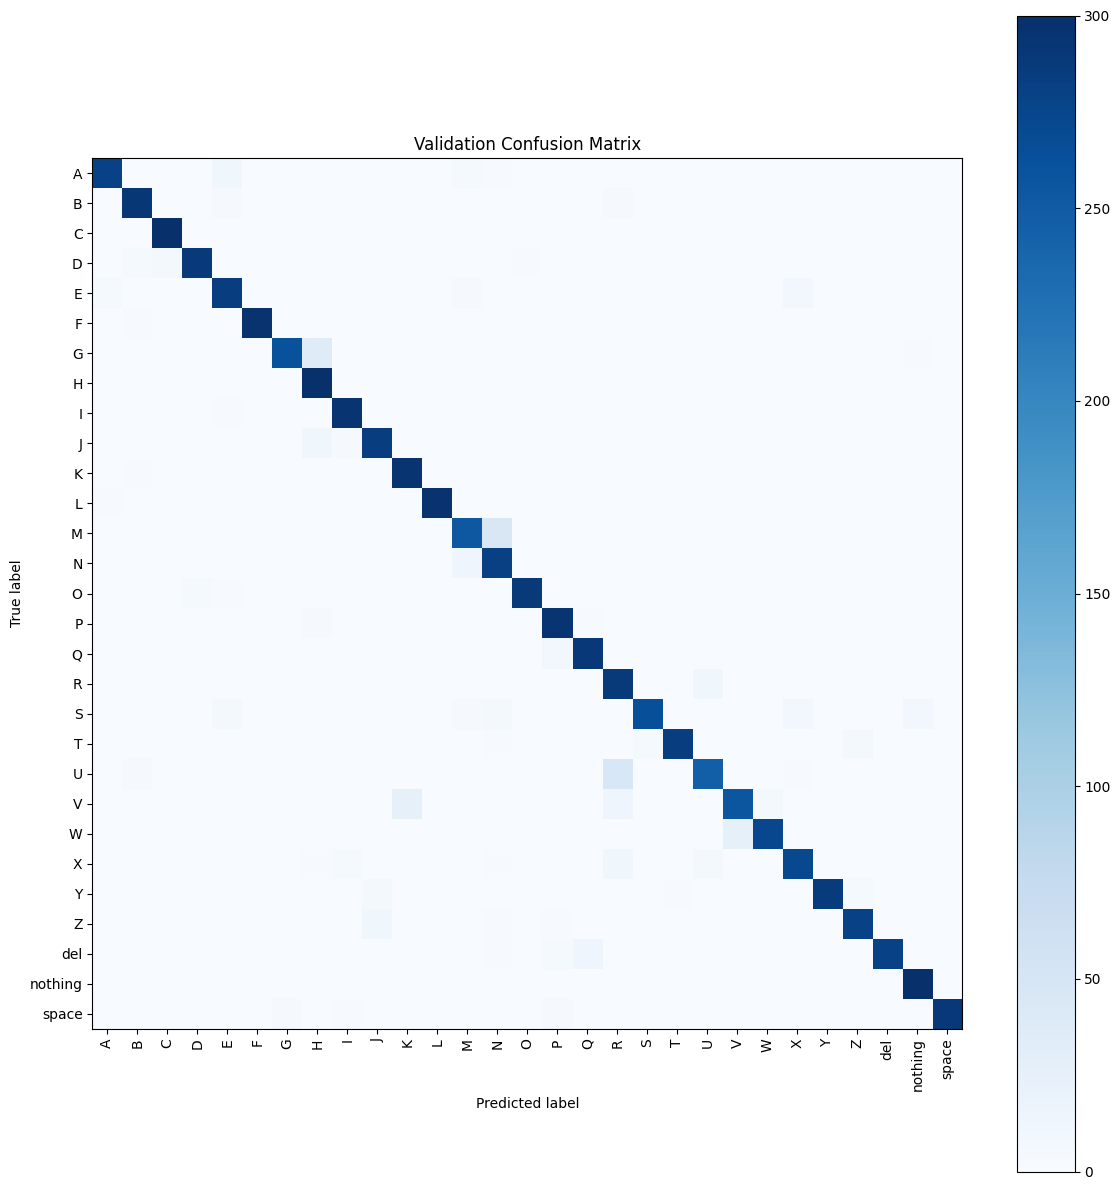

In [58]:
# Ewaluacja na walidacyjnym
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Validation loss:     {val_loss:.4f}")

# Predykcje na walidacyjnym
y_val_pred_probs = model.predict(val_generator)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = val_generator.classes
val_class_labels = list(val_generator.class_indices.keys())

# Raport klasyfikacji walidacyjny
print("\nValidation Classification Report:\n")
print(classification_report(y_val_true, y_val_pred, target_names=val_class_labels, zero_division=0))

# Macierz pomyłek walidacyjna
cm_val = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(12, 12))
plt.imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(val_class_labels)), val_class_labels, rotation=90)
plt.yticks(np.arange(len(val_class_labels)), val_class_labels)
plt.colorbar()
plt.tight_layout()
plt.show()
